In [1]:
#This notebook was used to train a transformer model with sum of stds reg loss (0.5 of weight)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import Sequence
from keras.layers import Conv2D, MaxPooling2D
from qkeras import *

from keras.utils import Sequence
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from loss import custom_loss

import os
import random

pi = 3.14159265359

maxval=1e9
minval=1e-9

2025-04-16 21:41:27.814389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 21:41:27.814454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 21:41:27.815315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 21:41:27.825884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 21:41:28.845798: W tensorflow/compiler/tf2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#from dataprep import *
from OptimizedDataGenerator import OptimizedDataGenerator
import tensorflow_probability as tfp
from models import *

2025-04-16 21:41:32.215899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 7g.40gb, pci bus id: 0000:81:00.0, compute capability: 8.0


In [4]:
batch_size = 5000
val_batch_size = 5000
train_file_size = 50  # Make this larger (150?)
val_file_size = 10

dataset_base_dir = f'/depot/cms/users/das214/dataset8/unflipped/'
tfrecords_base_dir = os.path.expanduser("~/TFrecords/")
os.makedirs(tfrecords_base_dir, exist_ok=True)

data_directory_path = os.path.join(dataset_base_dir, 'recon3D/')
labels_directory_path = os.path.join(dataset_base_dir, 'labels/')

tfrecords_dir_train = os.path.join(tfrecords_base_dir, 'TFR_train')
tfrecords_dir_validation = os.path.join(tfrecords_base_dir, 'TFR_val')

print("Nuevo directorio para train:", tfrecords_dir_train)
print("Nuevo directorio para validation:", tfrecords_dir_validation)

# validation_generator = OptimizedDataGenerator(
#      data_directory_path = data_directory_path,
#      labels_directory_path = labels_directory_path,
#      is_directory_recursive = False,
#      file_type = "parquet",
#      data_format = "3D",
#      batch_size = val_batch_size,
#      file_count = val_file_size,
#      to_standardize= True,
#      include_y_local= False, 
#      labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
#      input_shape = (2,13,21), # (20,13,21),
#      transpose = (0,2,3,1),
#      shuffle = False, 
#      files_from_end=True,
#      tfrecords_dir = tfrecords_dir_validation,
#      use_time_stamps = [0, 19], #-1
#      max_workers = 1 # Don't make this too large (will use up all RAM)
#  )

# training_generator = OptimizedDataGenerator(
#      data_directory_path = data_directory_path,
#      labels_directory_path = labels_directory_path,
#      is_directory_recursive = False,
#      file_type = "parquet",
#      data_format = "3D",
#      batch_size = batch_size,
#      file_count = train_file_size,
#      to_standardize= True,
#      include_y_local= False,
#      labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
#      input_shape = (2,13,21), # (20,13,21),
#      transpose = (0,2,3,1),
#      shuffle = False, # True 

#      tfrecords_dir = tfrecords_dir_train,
#      use_time_stamps = [0, 19], #-1
#      max_workers = 1 # Don't make this too large (will use up all RAM)
#  )

training_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_train,
    shuffle = True,
    seed = 13,
    quantize = True
)

validation_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_validation,
    shuffle = True,
    seed = 13,
    quantize = True
)

Nuevo directorio para train: /home/callea/TFrecords/TFR_train
Nuevo directorio para validation: /home/callea/TFrecords/TFR_val


In [5]:
print(len(os.listdir(data_directory_path)))
print(len(os.listdir(labels_directory_path)))

160
160


In [6]:
path_1 = os.listdir(data_directory_path)[0]
path_1 = os.path.join(data_directory_path, path_1)

import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_parquet(path_1)

In [7]:
x = df1.iloc[0]

data_files_path_list = os.listdir(data_directory_path)
labels_files_path_list = os.listdir(labels_directory_path)

data_df = pd.read_parquet(os.path.join(data_directory_path, data_files_path_list[0])) 
labels_df = pd.read_parquet(os.path.join(labels_directory_path, labels_files_path_list[0]))



In [8]:
len(df1)

49999

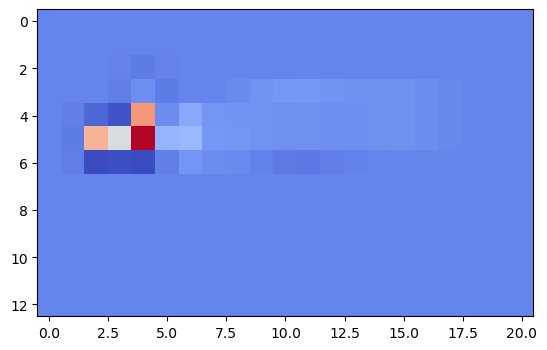

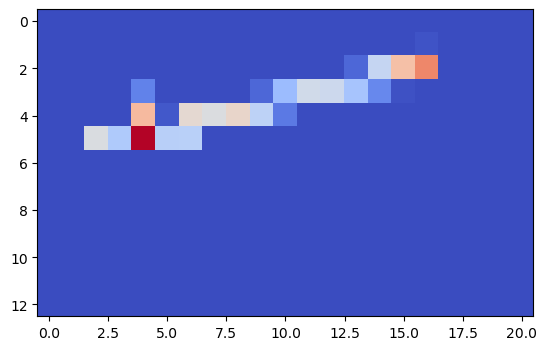

In [9]:
reshaped_data = x.values.reshape(20, 13, 21)

plt.imshow(reshaped_data[0,:,:], cmap='coolwarm') # first time-step
plt.show()
plt.imshow(reshaped_data[-1,:,:], cmap='coolwarm') # Last time-step
plt.show()

In [10]:
reshaped_data[0,:,:]

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3600e+01, -1.0760e+02,
        -1.7900e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -7.0800e+01

In [11]:
class PatchExtractor(layers.Layer):
  """Extract 2D patches from images."""
  def __init__(self, patch_size=(3,7)):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    patch_h, patch_w = self.patch_size
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_h, patch_w, 1),
        strides=(1, patch_h, patch_w, 1),
        rates=(1,1,1,1),
        padding='VALID'
    )
    patch_dims = tf.shape(patches)[-1]
    patches = tf.reshape(
        patches,
        [batch_size, -1, patch_dims]
    )
    return patches

class PatchEncoder(layers.Layer):
  """Linear embedding + learnable positional encoding."""
  def __init__(self, num_patches, embed_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection  = layers.Dense(embed_dim)
    self.pos_embed   = tf.Variable(
        initial_value=tf.zeros((1,num_patches,embed_dim)),
        trainable=True,
        name="pos_embedding"
    )

  def call(self, patch_batch):
    projected = self.projection(patch_batch)
    return projected + self.pos_embed

def transformer_encoder(inputs,
                        head_size,
                        num_heads,
                        ff_dim,
                        dropout=0.1):
  # LayerNorm + Multi-head attention
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(num_heads=num_heads,
                                key_dim=head_size,
                                dropout=dropout)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs
  
  # LN + feed-forward (mlp)
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Dense(ff_dim, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Dense(inputs.shape[-1], activation="linear")(x)
  x = layers.Dropout(dropout)(x)
  
  return x + res

def create_vit_model(input_shape=(13,21,2),
                     patch_size=(3,7),
                     embed_dim=64,
                     num_heads=4,
                     ff_dim=128,
                     num_layers=4,
                     dropout=0.1,
                     final_outputs=14):
  inputs = layers.Input(shape=input_shape)
  patches = PatchExtractor(patch_size=patch_size)(inputs)
  
  H, W, C = input_shape
  ph, pw  = patch_size
  num_patches = (H // ph) * (W // pw)

  encoded_patches = PatchEncoder(num_patches, embed_dim)(patches)

  x = encoded_patches
  for _ in range(num_layers):
    x = transformer_encoder(x,
                            head_size=embed_dim,
                            num_heads=num_heads,
                            ff_dim=ff_dim,
                            dropout=dropout)
  
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, activation='relu')(x)
  outputs = layers.Dense(final_outputs, activation='linear')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

model = create_vit_model(
    input_shape=(13,21,2),   
    patch_size=(3,7),        
    embed_dim=64,            
    num_heads=4,             
    ff_dim=128,              
    num_layers=4,           
    dropout=0.1,             
    final_outputs=14         
)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 21, 2)]          0         []                            
                                                                                                  
 patch_extractor (PatchExtr  (None, None, 42)             0         ['input_1[0][0]']             
 actor)                                                                                           
                                                                                                  
 patch_encoder (PatchEncode  (None, 12, 64)               3520      ['patch_extractor[0][0]']     
 r)                                                                                               
                                                                                              

In [12]:
import tensorflow_probability as tfp
from tensorflow.keras.metrics import Mean
from utils import track_loss_values

def custom_loss(y, p_base, minval=1e-9, maxval=1e9, scale = 512, reg_weight=0.5):
    
    p = p_base
    
    mu = p[:, 0:8:2]
    
    # creating each matrix element in 4x4
    Mdia = minval + tf.math.maximum(p[:, 1:8:2], 0.0)
    Mcov = p[:,8:]
    
    # placeholder zero element
    zeros = tf.zeros_like(Mdia[:,0])
    
    # assembles scale_tril matrix
    row1 = tf.stack([Mdia[:,0],zeros,zeros,zeros])
    row2 = tf.stack([Mcov[:,0],Mdia[:,1],zeros,zeros])
    row3 = tf.stack([Mcov[:,1],Mcov[:,2],Mdia[:,2],zeros])
    row4 = tf.stack([Mcov[:,3],Mcov[:,4],Mcov[:,5],Mdia[:,3]])

    scale_tril = tf.transpose(tf.stack([row1,row2,row3,row4]),perm=[2,0,1])

    dist = tfp.distributions.MultivariateNormalTriL(loc = mu, scale_tril = scale_tril) 
    
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)

    cov_matrix = tf.matmul(scale_tril, tf.transpose(scale_tril, [0, 2, 1])) 
    variances = tf.linalg.diag_part(cov_matrix)
    stds = tf.sqrt(variances + minval)

    sigma_regularizer_1 = tf.reduce_sum(stds, axis=1)

    track_loss_values(NLL, reg_weight * sigma_regularizer_1)

    total_loss = NLL + (reg_weight * sigma_regularizer_1)
    
    return tf.keras.backend.sum(total_loss)

In [13]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_loss)

In [14]:
fingerprint = '%08x' % random.randrange(16**8)
os.makedirs("trained_models", exist_ok=True)
base_dir = f'./trained_models/model-{fingerprint}-checkpoints'
os.makedirs(base_dir, exist_ok=True)  
checkpoint_filepath = base_dir + '/weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5'

In [15]:
print(fingerprint)

0f649086


In [16]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, Callback
from utils import get_loss_metrics, reset_loss_trackers
import csv

early_stopping_patience = 50

class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        checkpoints = [f for f in os.listdir(base_dir) if f.startswith('weights')]
        if len(checkpoints) > 1:
            checkpoints.sort()
            for checkpoint in checkpoints[:-1]:
                os.remove(os.path.join(base_dir, checkpoint))

class PrintSelectiveEpochLoss(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        reset_loss_trackers()
        
    def on_epoch_end(self, epoch, logs=None):
        # Obtener métricas actuales del NLL y el término de regularización ya ponderado
        metrics = get_loss_metrics()
        
        nll = metrics['nll']
        reg = metrics['reg_term'] 
        total = nll + reg

        print(f"🔁 Epoch {epoch + 1} - NLL: {nll:.4f} | Reg (weighted): {reg:.4f} | Total approx: {total:.4f}")

es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

print_epoch_loss = PrintSelectiveEpochLoss()

csv_logger = CSVLogger(f'{base_dir}/training_log.csv', append=True)

In [17]:
history = model.fit(
        x=training_generator,
        validation_data=validation_generator,
        callbacks=[es, mcp, csv_logger, print_epoch_loss],
        epochs=1000,
        shuffle=False,
        steps_per_epoch=len(training_generator),
        validation_steps=len(validation_generator),
        verbose=1
    )

2025-04-16 21:41:39.201102: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/1000


2025-04-16 21:41:46.553127: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x561180daaaf0
2025-04-16 21:41:46.934234: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f84b30613b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-16 21:41:46.934296: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 7g.40gb, Compute Capability 8.0
2025-04-16 21:41:46.940538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-16 21:41:46.970252: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1744832507.069571  674412 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


499/499 [==============================] - ETA: 0s - loss: 13376.2285
Epoch 1: val_loss improved from inf to -1835.83594, saving model to ./trained_models/model-0f649086-checkpoints/weights.01-t13376.23-v-1835.84.hdf5
🔁 Epoch 1 - NLL: 1.3292 | Reg (weighted): 0.8462 | Total approx: 2.1754
499/499 [==============================] - 67s 109ms/step - loss: 13376.2285 - val_loss: -1835.8359
Epoch 2/1000
499/499 [==============================] - ETA: 0s - loss: -10932.8594
Epoch 2: val_loss improved from -1835.83594 to -23841.68555, saving model to ./trained_models/model-0f649086-checkpoints/weights.02-t-10932.86-v-23841.69.hdf5
🔁 Epoch 2 - NLL: -2.9243 | Reg (weighted): 0.3062 | Total approx: -2.6181
499/499 [==============================] - 48s 95ms/step - loss: -10932.8594 - val_loss: -23841.6855
Epoch 3/1000
499/499 [==============================] - ETA: 0s - loss: -22700.0527
Epoch 3: val_loss improved from -23841.68555 to -28022.22070, saving model to ./trained_models/model-0f64908

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 136: val_loss did not improve from -44566.09766
🔁 Epoch 136 - NLL: -8.6213 | Reg (weighted): 0.0710 | Total approx: -8.5504
499/499 [==============================] - 46s 91ms/step - loss: -42414.6797 - val_loss: -44076.0469
Epoch 137/1000
499/499 [==============================] - ETA: 0s - loss: -42508.9844
Epoch 137: val_loss did not improve from -44566.09766
🔁 Epoch 137 - NLL: -8.6397 | Reg (weighted): 0.0711 | Total approx: -8.5686
499/499 [==============================] - 46s 91ms/step - loss: -42508.9844 - val_loss: -44149.1250
Epoch 138/1000
499/499 [==============================] - ETA: 0s - loss: -42213.5586
Epoch 138: val_loss did not improve from -44566.09766
🔁 Epoch 138 - NLL: -8.5878 | Reg (weighted): 0.0720 | Total approx: -8.5159
499/499 [==============================] - 62s 125ms/step - loss: -42213.5586 - val_loss: -44048.1094
Epoch 139/1000
499/499 [==============================] - ETA: 0s - loss: -42522.4883
Epoch 139: val_loss improved from -44566.09766 